In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import keras
from keras import layers
import requests
import io

In [2]:
with tf.device('/GPU:0'):
  a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

In [3]:
c = tf.matmul(a, b)

In [4]:
c

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[22., 28.],
       [49., 64.]], dtype=float32)>

In [5]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
tf.debugging.set_log_device_placement(True)

In [7]:
response_y = requests.get("https://storage.googleapis.com/signai/y_interpolated.npy")
response_X = requests.get("https://storage.googleapis.com/signai/X_interpolated.npy")

In [8]:
y = np.load(io.BytesIO(response_y.content))
X = np.load(io.BytesIO(response_X.content))

In [9]:
y = to_categorical(y)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [11]:
X_train, X_test = X_train[:,:100,:], X_test[:,:100,:]

In [12]:
X_train.shape

(2100, 100, 1662)

In [13]:
y_train.shape

(2100, 6)

In [14]:
del X

In [15]:
del y

In [16]:
X_pose_train, X_face_train, X_lh_train, X_rh_train = X_train[:,:,:132],X_train[:,:,132:1536],X_train[:,:,1536:1599],X_train[:,:,1599:1662]

In [17]:
X_pose_test, X_face_test, X_lh_test, X_rh_test = X_test[:,:,:132],X_test[:,:,132:1536],X_test[:,:,1536:1599],X_test[:,:,1599:1662]

In [18]:
X_lh_test.shape

(900, 100, 63)

In [45]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, LSTM, Dense, concatenate,
                                     MultiHeadAttention)
import keras

# Input layers
input_pose = Input(shape=(100, 132), name='pose')
input_face = Input(shape=(100, 1404), name='face')
input_rh = Input(shape=(100, 63), name='rh')
input_lh = Input(shape=(100, 63), name='lh')

# MultiHeadAttention layers
mh_pose = MultiHeadAttention(num_heads=5, key_dim=5)(input_pose, input_pose)
mh_face = MultiHeadAttention(num_heads=5, key_dim=5)(input_face, input_face)
mh_rh = MultiHeadAttention(num_heads=5, key_dim=5)(input_rh, input_rh)
mh_lh = MultiHeadAttention(num_heads=5, key_dim=5)(input_lh, input_lh)

# LSTM layers
lstm_pose = LSTM(70, kernel_initializer='he_normal', return_sequences=True)(mh_pose)
lstm_face = LSTM(70, kernel_initializer='he_normal', return_sequences=True)(mh_face)
lstm_rh = LSTM(70, kernel_initializer='he_normal', return_sequences=True)(mh_rh)
lstm_lh = LSTM(70, kernel_initializer='he_normal', return_sequences=True)(mh_lh)

lstm_pose = LSTM(70, kernel_initializer='he_normal', return_sequences=False)(lstm_pose)
lstm_face = LSTM(70, kernel_initializer='he_normal', return_sequences=False)(lstm_face)
lstm_rh = LSTM(70, kernel_initializer='he_normal', return_sequences=False)(lstm_rh)
lstm_lh = LSTM(70, kernel_initializer='he_normal', return_sequences=False)(lstm_lh)

# Dense layers
dense_pose = Dense(40, activation='relu')(lstm_pose)
dense_face = Dense(40, activation='relu')(lstm_face)
dense_rh = Dense(40, activation='relu')(lstm_rh)
dense_lh = Dense(40, activation='relu')(lstm_lh)

# Concatenate
concat_layer = concatenate([dense_pose, dense_face, dense_rh, dense_lh])

# Final Dense layers
dense_1 = Dense(32, activation='relu')(concat_layer)
output = Dense(6, activation='softmax')(dense_1)

# Create Model
model = tf.keras.Model(inputs=[input_pose, input_face, input_rh, input_lh], outputs=output)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[keras.metrics.Precision(),
                       keras.metrics.Recall(),
                       keras.metrics.AUC(),
                       keras.metrics.CategoricalAccuracy()])

# Print model summary
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 pose (InputLayer)           [(None, 100, 132)]           0         []                            
                                                                                                  
 face (InputLayer)           [(None, 100, 1404)]          0         []                            
                                                                                                  
 rh (InputLayer)             [(None, 100, 63)]            0         []                            
                                                                                                  
 lh (InputLayer)             [(None, 100, 63)]            0         []                            
                                                                                            

In [46]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[keras.metrics.Precision(),keras.metrics.Recall(),keras.metrics.AUC(),keras.metrics.CategoricalAccuracy()])

In [35]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 pose (InputLayer)           [(None, 100, 132)]           0         []                            
                                                                                                  
 face (InputLayer)           [(None, 100, 1404)]          0         []                            
                                                                                                  
 rh (InputLayer)             [(None, 100, 63)]            0         []                            
                                                                                                  
 lh (InputLayer)             [(None, 100, 63)]            0         []                            
                                                                                            

In [47]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0)
tensorboard = TensorBoard(log_dir='./logs')
checkpoint = ModelCheckpoint('model_best_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [48]:
with tf.device('/GPU:0'):
  model.fit([X_pose_train, X_face_train ,X_rh_train, X_lh_train], y_train, epochs=50,validation_split=0.3, batch_size=32,callbacks=[early_stop, reduce_lr, tensorboard, checkpoint])

Epoch 1/50
45/46 [============================>.] - ETA: 0s - loss: 1.3456 - precision_5: 0.5556 - recall_5: 0.0729 - auc_5: 0.8153 - categorical_accuracy: 0.3868
Epoch 1: val_loss improved from inf to 1.11611, saving model to model_best_weights.h5
46/46 [==============================] - 21s 137ms/step - loss: 1.3375 - precision_5: 0.5600 - recall_5: 0.0762 - auc_5: 0.8178 - categorical_accuracy: 0.3891 - val_loss: 1.1161 - val_precision_5: 0.6768 - val_recall_5: 0.1762 - val_auc_5: 0.8759 - val_categorical_accuracy: 0.5222 - lr: 0.0010
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/46 [============================>.] - ETA: 0s - loss: 0.9708 - precision_5: 0.6009 - recall_5: 0.3576 - auc_5: 0.8976 - categorical_accuracy: 0.5639
Epoch 2: val_loss improved from 1.11611 to 0.82395, saving model to model_best_weights.h5
46/46 [==============================] - 3s 62ms/step - loss: 0.9663 - precision_5: 0.6052 - recall_5: 0.3619 - auc_5: 0.8988 - categorical_accuracy: 0.5673 - val_loss: 0.8239 - val_precision_5: 0.7347 - val_recall_5: 0.5714 - val_auc_5: 0.9330 - val_categorical_accuracy: 0.6905 - lr: 0.0010
Epoch 3/50
45/46 [============================>.] - ETA: 0s - loss: 0.6982 - precision_5: 0.7559 - recall_5: 0.6840 - auc_5: 0.9497 - categorical_accuracy: 0.7306
Epoch 3: val_loss improved from 0.82395 to 0.57220, saving model to model_best_weights.h5
46/46 [==============================] - 2s 52ms/step - loss: 0.6943 - precision_5: 0.7566 - recall_5: 0.6850 - auc_5: 0.9503 - categorical_accuracy: 0.7313 - val_loss: 0.5722 - val_precision_5: 0.7821 - val_reca

In [24]:
model.save('./model.keras')

In [25]:
#from numba import cuda
#device = cuda.get_current_device()
#device.reset()

In [49]:
with tf.device('/GPU:0'):
  y_pred = model.predict([X_pose_test, X_face_test, X_lh_test, X_rh_test])

29/29 [==============================] - 3s 22ms/step


In [50]:
y_pred = np.argmax(y_pred, axis=1).tolist()

In [51]:
y_true = np.argmax(y_test, axis=1).tolist()

In [52]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score,ConfusionMatrixDisplay, confusion_matrix


In [53]:
confusion_matrices = confusion_matrix(y_true, y_pred,labels=np.unique(y_pred), normalize='true')

In [54]:


confusion_matrices



array([[0.94086022, 0.        , 0.        , 0.        , 0.05913978],
       [0.00574713, 0.99425287, 0.        , 0.        , 0.        ],
       [0.1011236 , 0.        , 0.78651685, 0.        , 0.11235955],
       [0.01169591, 0.02339181, 0.00584795, 0.93567251, 0.02339181],
       [0.0052356 , 0.        , 0.0052356 , 0.06806283, 0.92146597]])

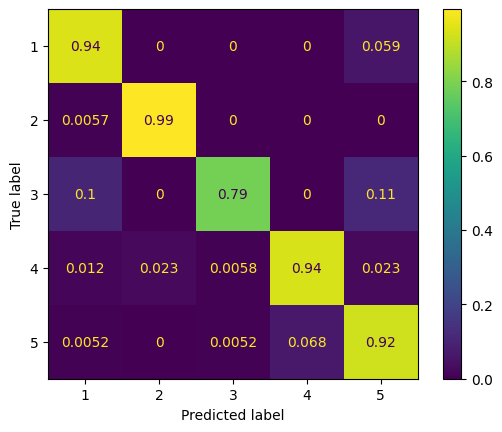

In [55]:
disp = ConfusionMatrixDisplay(confusion_matrices, display_labels=np.unique(y_pred))
disp.plot()
